# Query Palo Sessions into Neo4j Relational DB

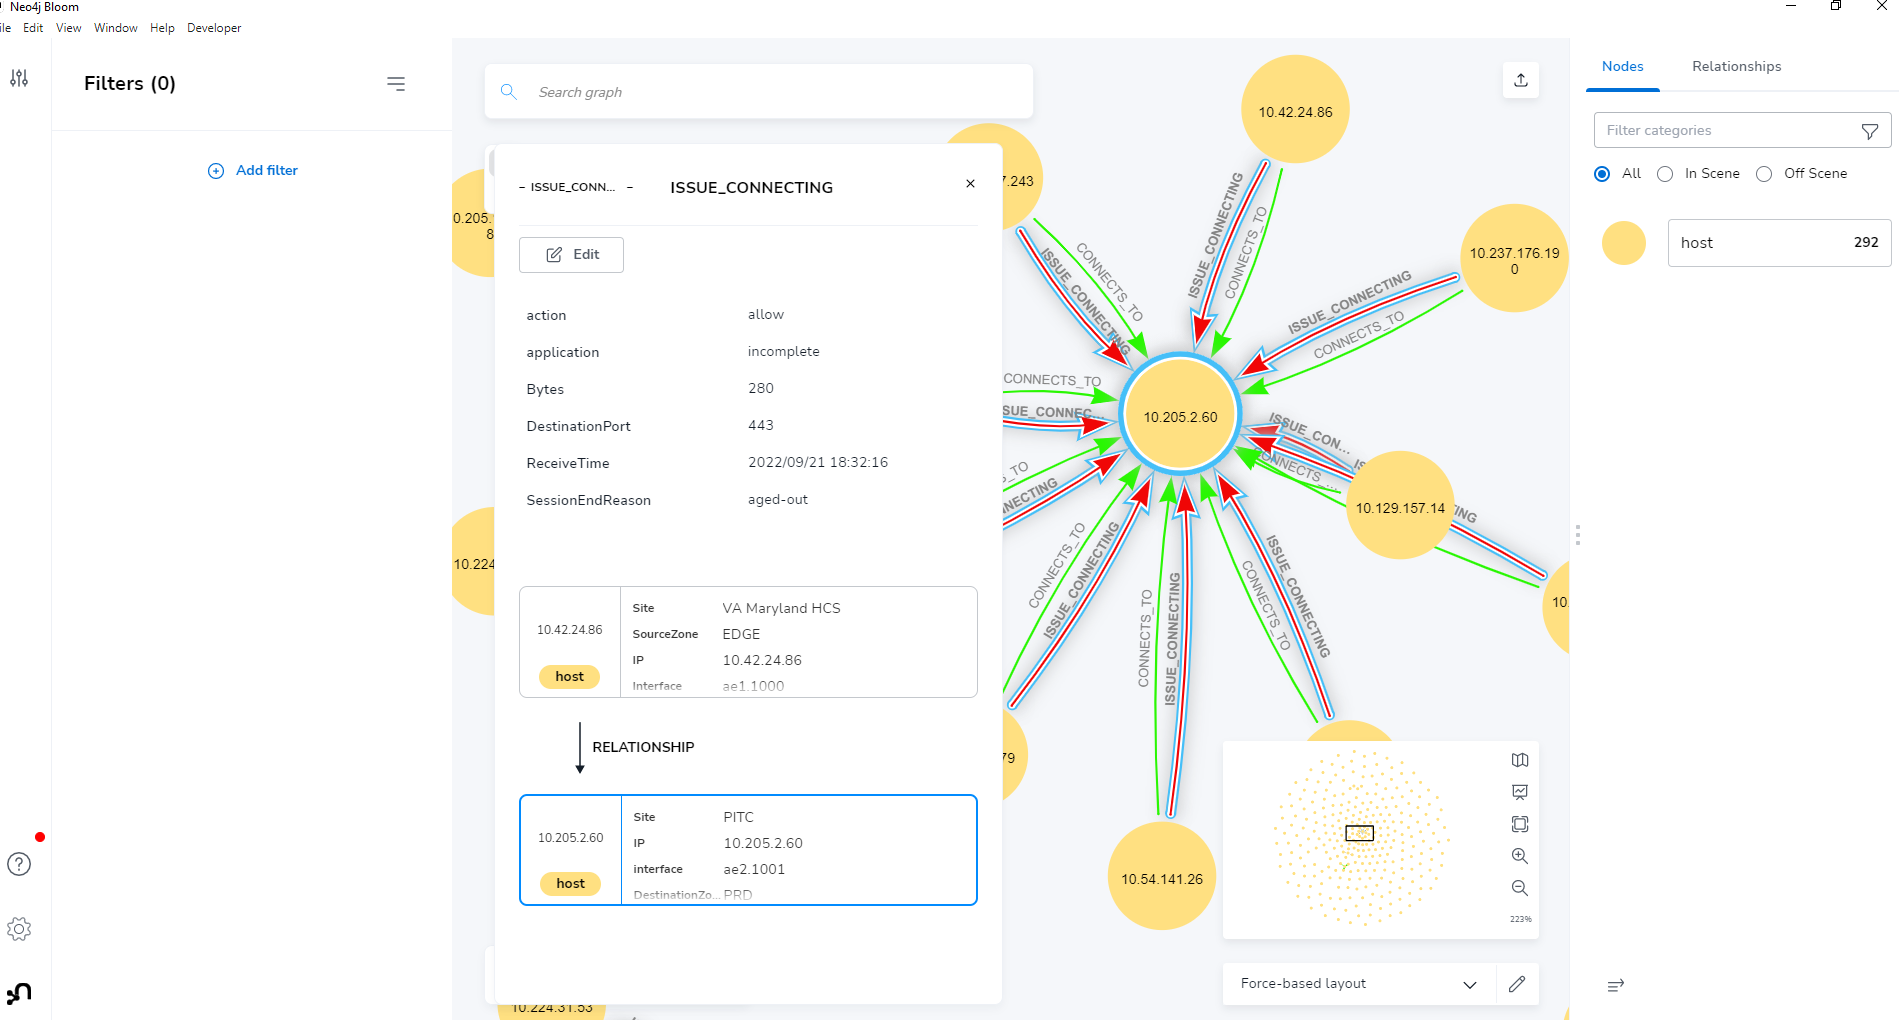

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
import re
from re import match
import getpass
import io
import os, json
import netmiko
from netmiko import ConnectHandler
from py2neo import Graph

# Palo Send Commands

In [6]:
def log_function(temp_command):
    pano.send_command("set cli pager off")
    pano.send_command("set cli scripting-mode on")
    print(temp_command)
    out=pano.send_command(temp_command,read_timeout=90)
    pano.send_command("set cli pager on")
    pano.send_command("set cli scripting-mode off")
    df=log_tocsv(out)
    return(df)

# Parse output from Palo to dataframe

In [7]:
def log_tocsv(out):
    i=0
    temp_list=[]
    df = pd.DataFrame()
    for line in out.split('\n'):
        if i < 4:
            i=i+1
        else:
            lines=list(line.split(","))
            temp_list.append(lines)
    df = pd.DataFrame(temp_list, columns = ['Domain', 'ReceiveTime', 'Serial#', 'Type', 'Threat/ContentType', 'ConfigVersion', 'GenerateTime', 'Sourceaddress', 'Destinationaddress', 'NATSourceIP', 'NATDestinationIP', 'Rule', 'SourceUser', 'DestinationUser', 'Application', 'VirtualSystem', 'SourceZone', 'DestinationZone', 'InboundInterface', 'OutboundInterface', 'LogAction', 'TimeLogged', 'SessionID', 'RepeatCount', 'SourcePort', 'DestinationPort', 'NATSourcePort', 'NATDestinationPort', 'Flags', 'IPProtocol', 'Action', 'Bytes', 'BytesSent', 'BytesReceived', 'Packets', 'StartTime', 'ElapsedTime(sec)', 'Category', 'tpadding', 'SequenceNumber', 'ActionFlags', 'SourceCountry', 'DestinationCountry', 'cpadding', 'PacketsSent', 'PacketsReceived', 'SessionEndReason', 'DGHierarchyLevel1', 'DGHierarchyLevel2', 'DGHierarchyLevel3', 'DGHierarchyLevel4', 'VirtualSystemName', 'DeviceName', 'ActionSource', 'SourceVMUUID', 'DestinationVMUUID', 'TunnelID/IMSI', 'MonitorTag/IMEI', 'ParentSessionID', 'ParentSessionStartTime', 'Tunnel', 'SCTPAssociationID', 'SCTPChunks', 'SCTPChunksSent', 'SCTPChunksReceived', 'UUIDforrule', 'HTTP/2Connection'])      
    return(df)

# User input, parse time and connect to panorama

### Don't forget to change your username
### You can do ip's or subnets, but time has to be in specific format: # minutes, # hours, # days

In [ ]:

src=input("enter Soruce IP or net:") 
dst=input("enter destination IP or net:") 
port=input("enter destination port:") 
time=input("enter time e.g. 2 hours:")
#listRes = list(time.split(" "))
#end = datetime.today()
#r = re.compile('\d')
#match_list=list(filter(r.match, listRes))
#digit=int(match_list[0])

if match_list: 

    r = re.compile('sec')
    match_list=list(filter(r.match, listRes))
    if match_list:
        start = end - timedelta(seconds=digit)
    r = re.compile('ho')
    match_list=list(filter(r.match, listRes))
    if match_list:
        start = end - timedelta(hours=digit)
    r = re.compile('da')
    match_list=list(filter(r.match, listRes))
    if match_list:
        start = end - timedelta(days=digit)
    r = re.compile('min')
    match_list=list(filter(r.match, listRes))
    if match_list:
        start = end - timedelta(minutes=digit)
    fmt = "%Y/%m/%d@%H:%M:%S"
    end_time = end.strftime(fmt).upper()
    start_time = start.strftime(fmt).upper()
else:
    pass

print("command you are sending show log traffic start-time equal "+start_time+" end-time equal "+end_time+" dport equal "+port+" dst in "+dst+" src in "+src+" csv-output equal yes")
temp_pass=getpass.getpass("enter password:")
pano = ConnectHandler(device_type='paloalto_panos', ip="", username="", password=temp_pass,fast_cli = False,global_delay_factor = 10,session_log= 'pa_output.txt')
#palo_log1=log_function("show log traffic start-time equal "+start_time+" end-time equal "+end_time+" dport equal "+port+" dst in "+dst+" src in "+src+" csv-output equal yes")
#palo_log2=log_function("show log traffic start-time equal "+start_time+" end-time equal "+end_time+" dport equal "+port+" dst in "+src+" src in "+dst+" csv-output equal yes")
palo_log1=log_function("show log traffic start-time equal 2022/10/03@16:15:00 end-time equal 2022/10/03@17:00:00 dst in 10.225.225.0/24 csv-output equal yes")
palo_log2=log_function("show log traffic start-time equal 2022/10/03@16:15:00 end-time equal 2022/10/03@17:00:00 src in 10.225.225.0/24 csv-output equal yes")

pano.disconnect()
palo_log = pd.concat([palo_log1,palo_log2], ignore_index=True)
print('fin')

# Where you conditionally seperate the logs for graphing...could do more could do less.

### Currently matching aged out's and Action deny as issues_df everything else as connects

In [52]:
palo_log = pd.read_csv (r'C:\Users\VBAPHCColleD\Downloads\logs.csv',skip_blank_lines=True) 
palo_log.dropna(how="all", inplace=True)
issues_df = palo_log.loc[(palo_log['Action'] == 'Deny') | 
                         (palo_log['SessionEndReason'] == 'aged-out')]
connects_df = palo_log.loc[(palo_log['Action'] != 'Deny') | 
                         (palo_log['SessionEndReason'] != 'aged-out')]
print(palo_log)


C:\Users\VBAPHCColleD\AppData\Local\Temp\1\ipykernel_5616\1894992845.py:1: DtypeWarning: Columns (1,3,4,5,6,7,8,11,14,15,16,17,18,19,20,21,28,29,30,35,37,40,41,42,46,52,53,65) have mixed types. Specify dtype option on import or set low_memory=False.
  palo_log = pd.read_csv (r'C:\Users\VBAPHCColleD\Downloads\logs.csv',skip_blank_lines=True)


      Domain      Receive Time      Serial #     Type Threat/Content Type  \
0        0.0  10/04/2022 17:03  1.070101e+10  TRAFFIC                 end   
1        0.0  10/04/2022 17:02  1.070101e+10  TRAFFIC                 end   
2        0.0  10/04/2022 17:03  1.070101e+10  TRAFFIC                 end   
3        0.0  10/04/2022 17:09  1.070101e+10  TRAFFIC                 end   
4        0.0  10/04/2022 17:03  1.070101e+10  TRAFFIC                 end   
...      ...               ...           ...      ...                 ...   
5426     0.0   10/03/2022 4:25  1.070101e+10  TRAFFIC                 end   
5427     0.0   10/03/2022 4:19  1.070101e+10  TRAFFIC                 end   
5428     0.0   10/03/2022 4:25  1.070101e+10  TRAFFIC                 end   
5429     0.0   10/03/2022 4:18  1.070101e+10  TRAFFIC                 end   
5430     0.0   10/03/2022 4:24  1.070101e+10  TRAFFIC                 end   

     ReceiveTime Column1  Sourceaddress Destinationaddress  NAT Source IP  

# Define your local neo4j

In [4]:
graph = Graph("bolt://localhost:7687", user="neo4j", password="temp",name="sessions")

# Push issue table to neo4j

### It try's to connect and gives you status. It then sets values from tabel into knowledge graph. parameters are the local table and $ are values from parameter.

In [54]:
try:
    graph.run("Match () Return 1 Limit 1")
    print('ok')
except Exception:
    print('not ok')
tx = graph.begin()
for index, row in issues_df.iterrows():
    tx.evaluate('''
    MERGE (s:host {IP: $Sourceaddress, Interface: $InboundInterface, SourceZone: $SourceZone, Site: $SourceCountry})
    MERGE (d:host{IP: $Destinationaddress, interface: $OutboundInterface, DestinationZone: $DestinationZone, Site: $DestinationCountry})
    CREATE (s)-[i:ISSUE_CONNECTING]->(d)
    SET i.Bytes = toInteger($Bytes),i.DestinationPort=$DestinationPort,i.ReceiveTime=$ReceiveTime,i.action=$Action,i.application=$Application,i.SessionEndReason=$SessionEndReason
    ''', parameters = {'Sourceaddress': row['Sourceaddress'], 'InboundInterface': row['InboundInterface'],'SourceZone': row['SourceZone'],'SourceCountry': row['SourceCountry'],'Destinationaddress': row['Destinationaddress'],'OutboundInterface': row['OutboundInterface'],'DestinationZone': row['DestinationZone'],'DestinationCountry': row['DestinationCountry'],'Bytes': row['Bytes'], 'DestinationPort': row['DestinationPort'],'ReceiveTime': row['ReceiveTime'],'Action': row['Action'],'Application': row['Application'],'SessionEndReason': row['SessionEndReason']})
graph.commit(tx)  

ok


# Push connects_to table to neo4j

### It try's to connect and gives you status. It then sets values from tabel into knowledge graph. parameters are the local table and $ are values from parameter.

In [55]:
try:
    graph.run("Match () Return 1 Limit 1")
    print('ok')
except Exception:
    print('not ok')
tx = graph.begin()
for index, row in connects_df.iterrows():
    tx.evaluate('''
    MERGE (s:host {IP: $Sourceaddress, Interface: $InboundInterface, SourceZone: $SourceZone, Site: $SourceCountry})
    MERGE (d:host{IP: $Destinationaddress, interface: $OutboundInterface, DestinationZone: $DestinationZone, Site: $DestinationCountry})
    CREATE (s)-[i:CONNECTS_TO]->(d)
    SET i.Bytes = toInteger($Bytes),i.DestinationPort=$DestinationPort,i.ReceiveTime=$ReceiveTime,i.action=$Action,i.application=$Application,i.SessionEndReason=$SessionEndReason
    ''', parameters = {'Sourceaddress': row['Sourceaddress'], 'InboundInterface': row['InboundInterface'],'SourceZone': row['SourceZone'],'SourceCountry': row['SourceCountry'],'Destinationaddress': row['Destinationaddress'],'OutboundInterface': row['OutboundInterface'],'DestinationZone': row['DestinationZone'],'DestinationCountry': row['DestinationCountry'],'Bytes': row['Bytes'], 'DestinationPort': row['DestinationPort'],'ReceiveTime': row['ReceiveTime'],'Action': row['Action'],'Application': row['Application'],'SessionEndReason': row['SessionEndReason']})
graph.commit(tx)  

ok


# Voila!
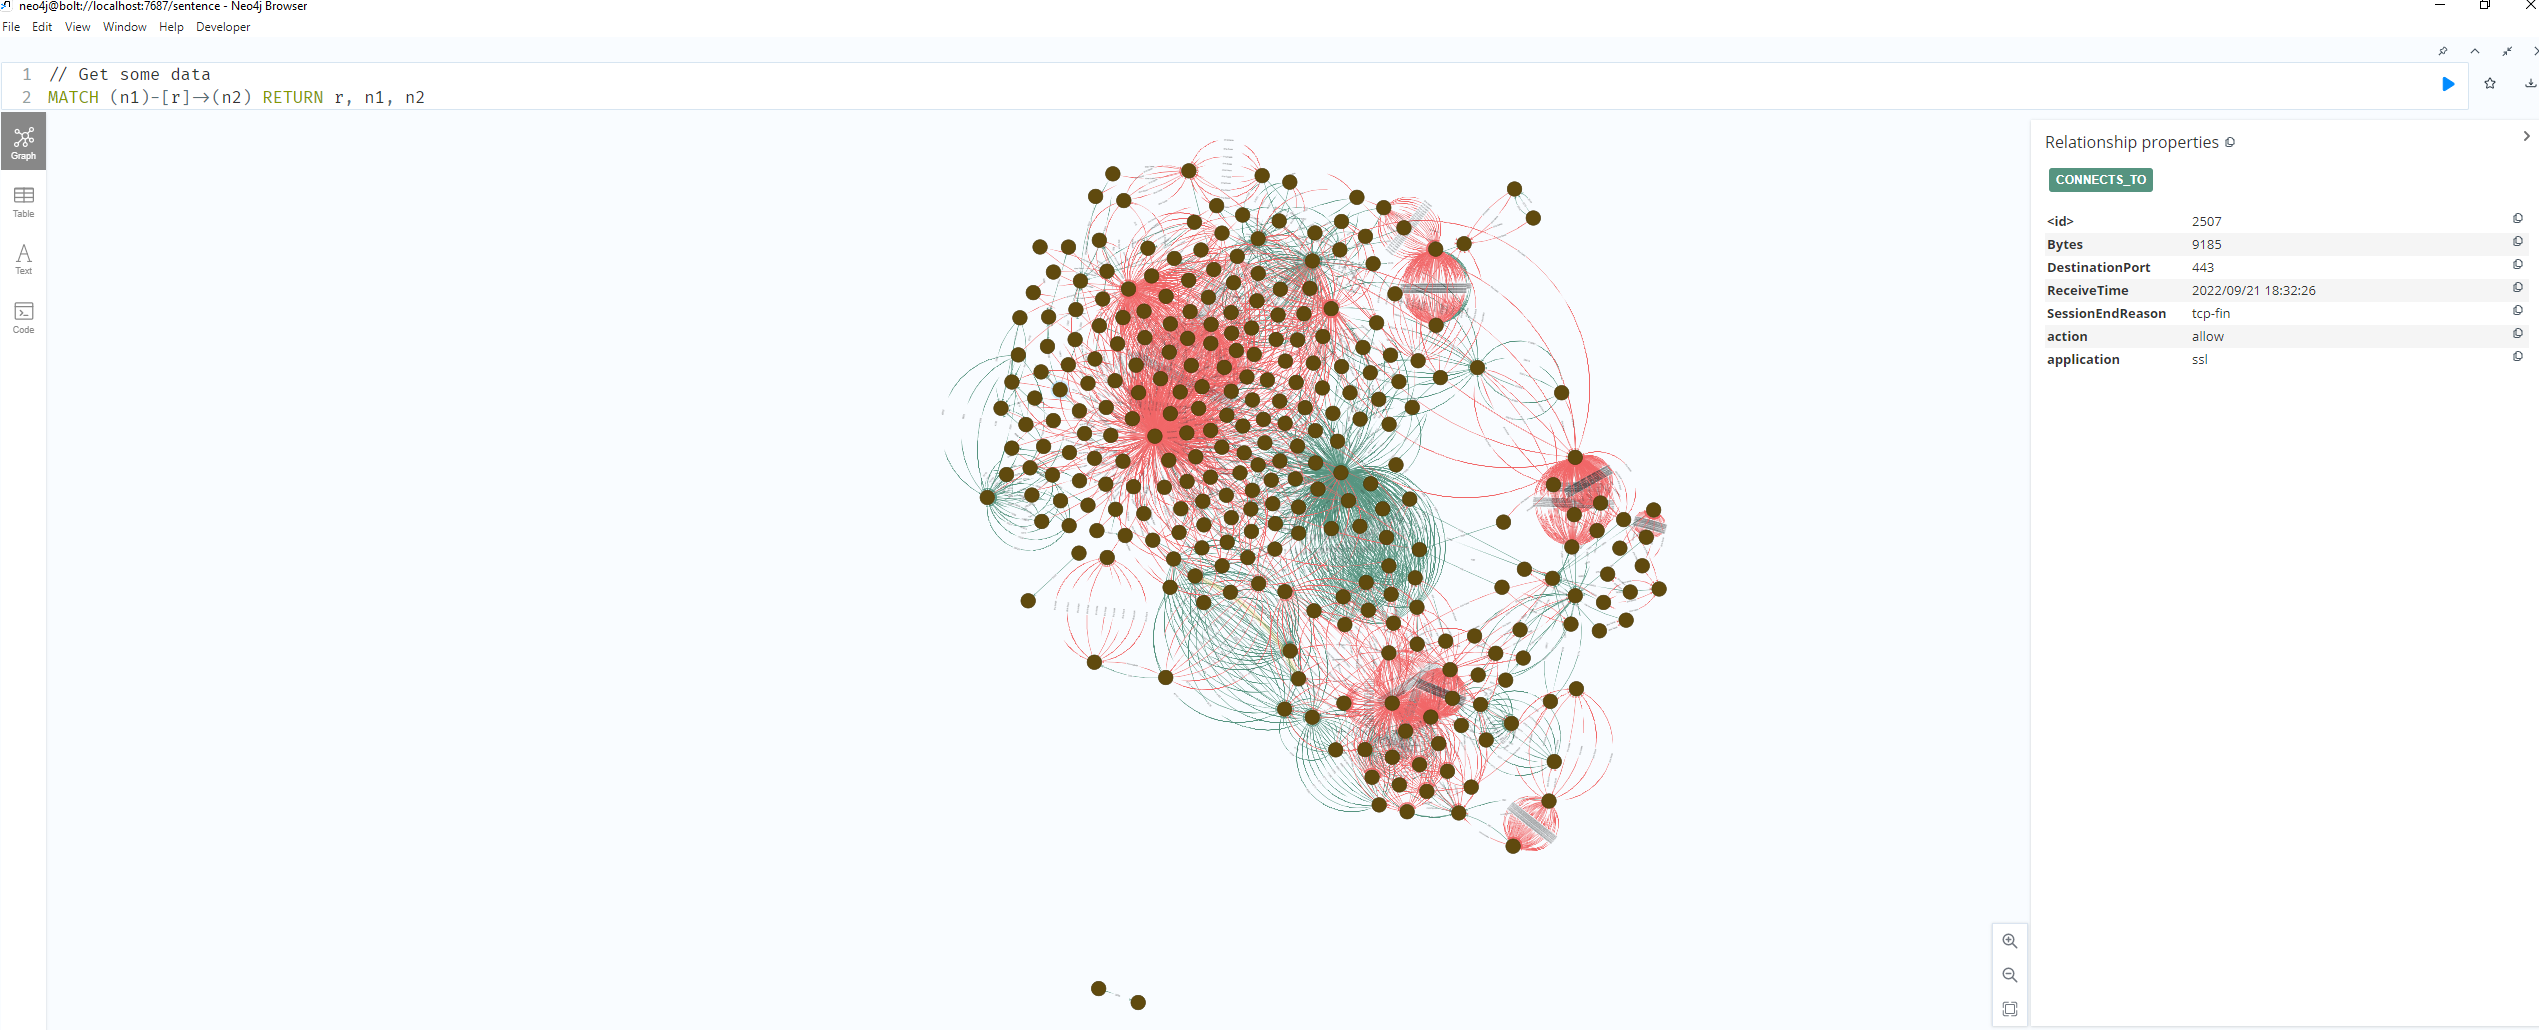

# Delete old connections from your local DB

In [53]:
try:
    graph.run("Match () Return 1 Limit 1")
    print('ok')
except Exception:
    print('not ok')
my_node = graph.run("MATCH (n) DETACH DELETE n")

ok


# Test to see you have data from your query

In [ ]:
print(palo_log)
#palo_log.to_csv("scan.csv",index=False)